1)взять претрейн resnet18 и поменять последний слой

2)тренить на обычном TIN

3)по резам из 2) найти легкие и сложные классы

4)уменьшить трейн

5)ещё раз тренить

6)сравнить резы 2) и 5)

# Download data

In [31]:
# !pip install kaggle

In [32]:
from pathlib import Path
import json
import os
import torch
from torchvision import datasets, transforms
import random
import numpy as np
import torch
from tqdm import tqdm

# your api key
# api_key = {"username":"spacehitchhiker","key":"c698b877d42f3f853d0a599e6263d8a8"}

# # uses pathlib Path
# kaggle_path = Path('/root/.kaggle')
# os.makedirs(kaggle_path, exist_ok=True)

# # opens file and dumps python dict to json object
# with open (kaggle_path/'kaggle.json', 'w') as handl:
#     json.dump(api_key,handl)

# os.chmod(kaggle_path/'kaggle.json', 600)

# !kaggle datasets download -d akash2sharma/tiny-imagenet --force

# !unzip -qq tiny-imagenet.zip

In [33]:
data_mean = (0.5071, 0.4865, 0.4409)
data_std = (0.2673, 0.2564, 0.2762)
transformation = transforms.Compose([
    # transforms.RandomHorizontalFlip(0.5),
    # transforms.RandomVerticalFlip(0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, .25, 0.25])
])

full_dataset = datasets.ImageFolder(
    root='Experiments/tiny-imagenet-200/train',
    transform=transformation
)

In [34]:
train_len = int(len(full_dataset)*0.7)
test_len = len(full_dataset) - train_len
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset,[train_len,test_len])
len(train_dataset)

70000

In [35]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=0,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=0,
    shuffle=True
)

In [36]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [37]:
n_epochs = 10

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
set_seed(42)

In [38]:
import torchvision
import torch.nn as nn

model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
model.fc = nn.Linear(512,200)
model = model.to(device)
# optimizer = torch.optim.Adam(model.fc.parameters(),lr=5e-4)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1)


loss_function = nn.CrossEntropyLoss()
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

for p in model.parameters():
    p.requires_grad = False
    
for p in model.fc.parameters():
    p.requires_grad = True

count_parameters(model)

102600

In [39]:
def train_test_cycle(model,train_loader,test_loader,optimizer,scheduler,loss_function,device,n_epochs=10,print_losses=False):
  losses_history = { 'train': [], 'test': [] }
  val_acc_history = []
  train_len = len(train_loader)
  val_len = len(test_loader)
  for i in range(n_epochs):
    model.train()
    train_loss = 0
    for x,y in tqdm(train_loader):
      optimizer.zero_grad()
      x, y = x.to(device), y.to(device)
      preds = model(x)
      loss = loss_function(preds,y)
      train_loss += loss
      loss.backward()
      optimizer.step()
    # scheduler.step()

    model.eval()
    val_loss = 0
    val_acc = 0
    with torch.no_grad():
      for x,y in  tqdm(test_loader):
         x, y = x.to(device), y.to(device)
         logits = model(x)
         preds = logits.max(dim=1)[1]
         val_acc += torch.mean((preds == y).float())
         loss = loss_function(logits,y)
         val_loss += loss

    train_loss = train_loss / train_len
    val_loss = val_loss / val_len
    val_acc = val_acc / val_len
    losses_history['train'].append(train_loss)
    losses_history['test'].append(val_loss)
    val_acc_history.append(val_acc) # 32 - batch size

    if print_losses:
      print(f'epoch {i}: train loss:{train_loss} val loss:{val_loss} val acc:{val_acc}')

  return model,losses_history,val_acc_history

In [40]:
model,losses_history_full,val_acc_history_full =train_test_cycle(model,train_loader,test_loader,
                                                                 optimizer,scheduler,loss_function,
                                                                 device,n_epochs=n_epochs,print_losses=True)

100%|██████████| 938/938 [01:11<00:00, 13.16it/s]


epoch 0: train loss:3.887544631958008 val loss:3.814448833465576 val acc:0.27808502316474915


100%|██████████| 938/938 [01:10<00:00, 13.34it/s]


epoch 1: train loss:3.605647563934326 val loss:3.8037309646606445 val acc:0.28814631700515747


100%|██████████| 938/938 [01:12<00:00, 12.94it/s]


epoch 2: train loss:3.5287256240844727 val loss:3.9094910621643066 val acc:0.2842150926589966


100%|██████████| 938/938 [01:23<00:00, 11.28it/s]


epoch 3: train loss:3.500267267227173 val loss:3.917275905609131 val acc:0.29027852416038513


100%|██████████| 938/938 [01:30<00:00, 10.37it/s]


epoch 4: train loss:3.4772884845733643 val loss:4.042745590209961 val acc:0.28008395433425903


100%|██████████| 938/938 [01:16<00:00, 12.32it/s]


epoch 5: train loss:3.469439744949341 val loss:4.01155948638916 val acc:0.2941431403160095


100%|██████████| 938/938 [01:40<00:00,  9.35it/s]


epoch 6: train loss:3.4784719944000244 val loss:4.073680400848389 val acc:0.2841484546661377


100%|██████████| 938/938 [01:35<00:00,  9.85it/s]


epoch 7: train loss:3.464904308319092 val loss:4.118938446044922 val acc:0.2843816578388214


100%|██████████| 938/938 [01:29<00:00, 10.51it/s]


epoch 8: train loss:3.4738056659698486 val loss:4.15089225769043 val acc:0.28091683983802795


100%|██████████| 938/938 [01:25<00:00, 11.00it/s]

epoch 9: train loss:3.4701426029205322 val loss:4.020843982696533 val acc:0.2933768630027771


In [41]:
print(losses_history_full)
print(val_acc_history_full)

{'train': [tensor(3.8875, device='cuda:0', grad_fn=<DivBackward0>), tensor(3.6056, device='cuda:0', grad_fn=<DivBackward0>), tensor(3.5287, device='cuda:0', grad_fn=<DivBackward0>), tensor(3.5003, device='cuda:0', grad_fn=<DivBackward0>), tensor(3.4773, device='cuda:0', grad_fn=<DivBackward0>), tensor(3.4694, device='cuda:0', grad_fn=<DivBackward0>), tensor(3.4785, device='cuda:0', grad_fn=<DivBackward0>), tensor(3.4649, device='cuda:0', grad_fn=<DivBackward0>), tensor(3.4738, device='cuda:0', grad_fn=<DivBackward0>), tensor(3.4701, device='cuda:0', grad_fn=<DivBackward0>)], 'test': [tensor(3.8144, device='cuda:0'), tensor(3.8037, device='cuda:0'), tensor(3.9095, device='cuda:0'), tensor(3.9173, device='cuda:0'), tensor(4.0427, device='cuda:0'), tensor(4.0116, device='cuda:0'), tensor(4.0737, device='cuda:0'), tensor(4.1189, device='cuda:0'), tensor(4.1509, device='cuda:0'), tensor(4.0208, device='cuda:0')]}
[tensor(0.2781, device='cuda:0'), tensor(0.2881, device='cuda:0'), tensor(0.28

#Find easy classes

In [42]:
class_count = dict(zip(range(200),[0]*200))
for _,y in tqdm(test_dataset):
  class_count[y] += 1

# class_count

100%|██████████| 30000/30000 [00:08<00:00, 3361.51it/s]


In [43]:
class_acc = dict(zip(range(200),[0]*200))

In [44]:
for x,y in tqdm(test_loader):
    x,y = x.to(device), y.to(device)
    logits = model(x)
    preds = logits.max(1)[1]
    for (predicted,target) in zip(preds,y):
      if predicted == target:
        class_acc[target.item()] += 1

for key in class_acc.keys():
  class_acc[key] /= class_count[key]

100%|██████████| 938/938 [00:13<00:00, 69.59it/s]


In [45]:
sorted_by_acc = sorted(class_acc.items(),key=lambda x:x[1])

easy_classes = [item[0] for item in sorted_by_acc[-20:]]
# easy_classes

# Construct smaller dataset

In [46]:
reduced_classes = easy_classes
for reduced_class in reduced_classes:
  class_count[reduced_class]  = int(class_count[reduced_class] *  0.7)

In [47]:
reduced_dataset = []
for sample in tqdm(train_dataset):
  if sample[1] in reduced_classes:
    if class_count[sample[1]]:
      class_count[sample[1]] -= 1
      reduced_dataset.append(sample)
  else:
    reduced_dataset.append(sample)

len(reduced_dataset)

100%|██████████| 70000/70000 [02:37<00:00, 444.13it/s]


65080

In [48]:
reduced_train_loader = torch.utils.data.DataLoader(
    reduced_dataset,
    batch_size=32,
    num_workers=0,
    shuffle=True
)

In [49]:
model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
model.fc = nn.Linear(512,200)
model = model.to(device)
# optimizer = torch.optim.Adam(model.fc.parameters(),lr=5e-4)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1)


loss_function = nn.CrossEntropyLoss()
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

for p in model.parameters():
    p.requires_grad = False
    
for p in model.fc.parameters():
    p.requires_grad = True

count_parameters(model)

102600

In [51]:
model2,losses_history_reduce,val_acc_history_reduce =train_test_cycle(model,reduced_train_loader,
                                                                      test_loader,optimizer,scheduler,
                                                                      loss_function,device,n_epochs=n_epochs,print_losses=True)


100%|██████████| 938/938 [01:52<00:00,  8.34it/s]


epoch 0: train loss:3.9693377017974854 val loss:3.815134286880493 val acc:0.2707555890083313


100%|██████████| 938/938 [00:13<00:00, 68.03it/s]


epoch 1: train loss:3.6496918201446533 val loss:3.8246796131134033 val acc:0.2861473858356476


100%|██████████| 938/938 [00:14<00:00, 64.96it/s]


epoch 2: train loss:3.582444906234741 val loss:3.902116537094116 val acc:0.2825160026550293


100%|██████████| 938/938 [00:13<00:00, 69.09it/s]


epoch 3: train loss:3.558182716369629 val loss:3.943065643310547 val acc:0.2835487723350525


100%|██████████| 938/938 [00:13<00:00, 69.62it/s]


epoch 4: train loss:3.5370655059814453 val loss:3.9655725955963135 val acc:0.2817164361476898


100%|██████████| 938/938 [00:14<00:00, 67.00it/s]


epoch 5: train loss:3.5218069553375244 val loss:4.001603603363037 val acc:0.2822827994823456


100%|██████████| 938/938 [00:13<00:00, 68.65it/s]


epoch 6: train loss:3.5370378494262695 val loss:4.1130876541137695 val acc:0.27658581733703613


100%|██████████| 938/938 [00:14<00:00, 63.88it/s]


epoch 7: train loss:3.5161983966827393 val loss:4.081319808959961 val acc:0.2828824818134308


100%|██████████| 938/938 [00:13<00:00, 68.57it/s]


epoch 8: train loss:3.505563497543335 val loss:4.168128490447998 val acc:0.2799840271472931


100%|██████████| 938/938 [00:13<00:00, 67.92it/s]

epoch 9: train loss:3.5016818046569824 val loss:4.139607906341553 val acc:0.28164979815483093


In [52]:
print(losses_history_reduce)
print(val_acc_history_reduce)

{'train': [tensor(3.9693, device='cuda:0', grad_fn=<DivBackward0>), tensor(3.6497, device='cuda:0', grad_fn=<DivBackward0>), tensor(3.5824, device='cuda:0', grad_fn=<DivBackward0>), tensor(3.5582, device='cuda:0', grad_fn=<DivBackward0>), tensor(3.5371, device='cuda:0', grad_fn=<DivBackward0>), tensor(3.5218, device='cuda:0', grad_fn=<DivBackward0>), tensor(3.5370, device='cuda:0', grad_fn=<DivBackward0>), tensor(3.5162, device='cuda:0', grad_fn=<DivBackward0>), tensor(3.5056, device='cuda:0', grad_fn=<DivBackward0>), tensor(3.5017, device='cuda:0', grad_fn=<DivBackward0>)], 'test': [tensor(3.8151, device='cuda:0'), tensor(3.8247, device='cuda:0'), tensor(3.9021, device='cuda:0'), tensor(3.9431, device='cuda:0'), tensor(3.9656, device='cuda:0'), tensor(4.0016, device='cuda:0'), tensor(4.1131, device='cuda:0'), tensor(4.0813, device='cuda:0'), tensor(4.1681, device='cuda:0'), tensor(4.1396, device='cuda:0')]}
[tensor(0.2708, device='cuda:0'), tensor(0.2861, device='cuda:0'), tensor(0.28

In [58]:
def tensor_to_list(t):
    return [el.item() for el in t]

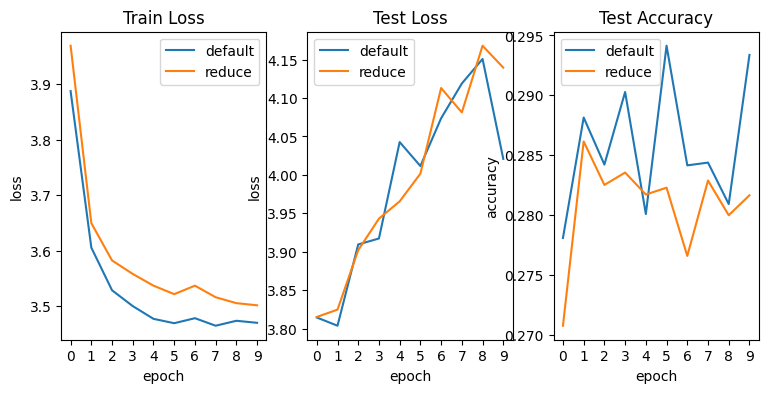

In [62]:
import matplotlib.pyplot as plt
fig,axes = plt.subplots(1,3,figsize=(9,4))

axes[0].plot(range(n_epochs), tensor_to_list(losses_history_full['train']),label='default')
axes[0].plot(range(n_epochs), tensor_to_list(losses_history_reduce['train']),label='reduce')
axes[0].set_title('Train Loss')

axes[1].plot(range(n_epochs), tensor_to_list(losses_history_full['test']),label='default')
axes[1].plot(range(n_epochs), tensor_to_list(losses_history_reduce['test']),label='reduce')
axes[1].set_title('Test Loss')


axes[2].plot(range(n_epochs), tensor_to_list(val_acc_history_full),label='default')
axes[2].plot(range(n_epochs), tensor_to_list(val_acc_history_reduce),label='reduce')
axes[2].set_title('Test Accuracy')

for index,ax in enumerate(axes):
  ax.set_xlabel('epoch')
  y_label = 'loss' if index < 2 else 'accuracy'
  ax.set_ylabel(y_label)
  ax.legend()
  ax.set_xticks(range(n_epochs))